In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import math

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Input

Using TensorFlow backend.


In [4]:
import callbacks
import losses
import utils
from models.AE import build_AE

# 1. Loading the data 

In [5]:
nc = Dataset('../Data/tohoku_2020.nc', 'r')
dim1 = int(np.array(nc.variables['lon']).shape[0])
dim2 = int(np.array(nc.variables['lat']).shape[0])
Z = np.flip(np.array(nc.variables['elevation']), axis=0) #otherwise the 'map' is upside down and mirrored

Plotting the full GEBCO may take time

In [6]:
#plt.figure(figsize=(10,5))
#plt.imshow(Z)

# 2. Pre-processing

#### Scale input into [0,1] where 0 is the global minimum and 1 global maximum. Necessary since the models were trained on the global data.

In [7]:
# min and max values from the global GEBCO 2019 version
Z_global_min = -10880.587890625
Z_global_max = 8613.15625


Z_min = Z_global_min
Z_max = Z_global_max + np.abs(Z_min)


Z = (Z + np.abs(Z_min)) / Z_max # is now in [0,1] of either local data domain or global

#### Break down into samples of size (x,y)

In [8]:
x, y = 96, 96

In [9]:
num_images = int(dim1*dim2 / (x*y))

cutoff_x = math.ceil(x * (dim1/x-int(dim1/x)))
cutoff_y = math.ceil(y * (dim2/y-int(dim2/y)))

number of images; amount of pixels lost on x-axis; y-axis

In [10]:
num_images, cutoff_x, cutoff_y

(17805, 66, 39)

#### Reshaping

In [11]:
data = np.zeros([num_images, y, x])
i=0
for r in range(0, Z.shape[0]-cutoff_y, y):
    for c in range(0, Z.shape[1]-cutoff_x, x):
        data[i, :, :] = Z[r:r+y, c:c+x]
        i = i + 1

#reshaping for keras model input
data = data.reshape(-1, y, x, 1)

# 3. Build model 

In [12]:
inputs  = Input(shape = (y, x, 1), name='encoder_inputs')

In [17]:
model = build_AE(inputs)
#model = build_VAE(inputs)
#model = build_VAE_DFC(inputs)

encoded = keras.models.Model(inputs=inputs, outputs=model.get_layer('encoded').output)

Model summary:

In [ ]:
#model.summary()

# 4. Load weights and get model output

In [14]:
model.load_weights('pre-trained_weights/AE.hd5')
#model.load_weights('pre-trained_weights/VAE.hdf5')
#model.load_weights('pre-trained_weights/VAE_DFC.hdf5')

In [30]:
data_reconstructed = model.predict(data)
data_encoded = np.mean(encoded.predict(data), axis=3, keepdims=True)

x_encoded = data_encoded.shape[1]
y_encoded = data_encoded.shape[2]

### plots

normalize reconstruction heat-map color coding?

In [33]:
normalize = True

In [32]:
Z_reconstructed = Z.copy()
Z_encoded = np.zeros([int(dim2/y)*y_encoded, int(dim1/x)*x_encoded])

i=0
for r in range(0, Z.shape[0]-cutoff_y, y):
    for c in range(0, Z.shape[1]-cutoff_x, x):
        Z_reconstructed[r:r+y, c:c+x] = data_reconstructed[i, ..., 0]
        i = i + 1

i=0
for r in range(0, Z_encoded.shape[0], y_encoded):
    for c in range(0, Z_encoded.shape[1], x_encoded):
        Z_encoded[r:r+y_encoded, c:c+x_encoded] = data_encoded[i, ..., 0]
        i = i + 1

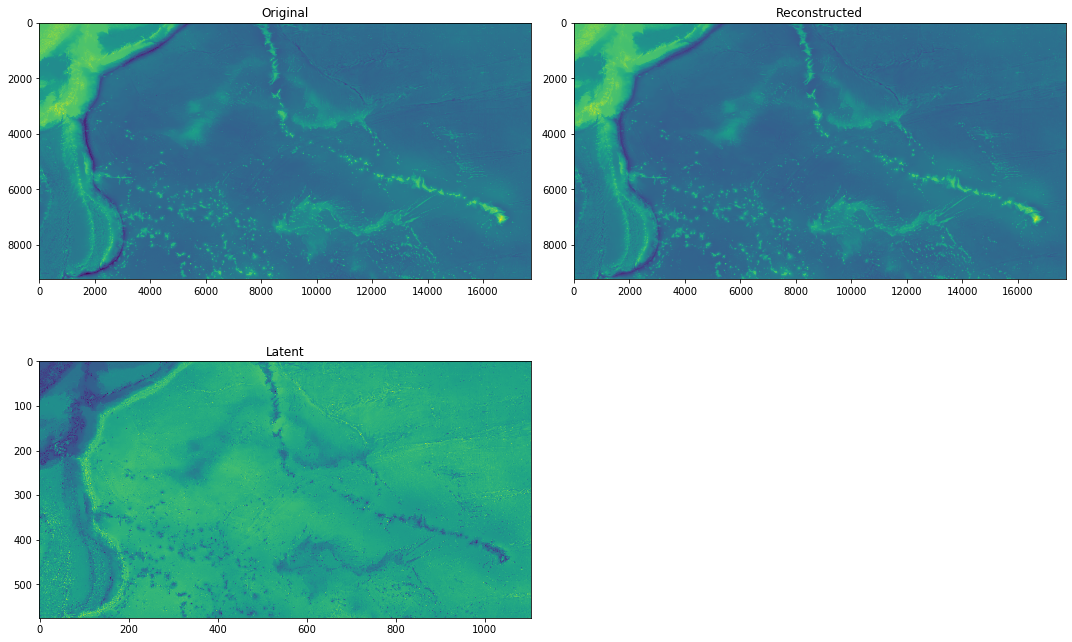

In [36]:
vmin = np.min(Z)
vmax = np.max(Z)

if normalize:
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
else:
    norm = None

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(Z, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.subplot(2,2,2)
plt.title("Reconstructed")
plt.imshow(Z_reconstructed, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.subplot(2,2,3)
plt.title("Latent")
plt.imshow(Z_encoded)

plt.tight_layout()
plt.subplots_adjust(hspace=-0.53)

### errors

In [38]:
error = np.linalg.norm(data - data_reconstructed, axis=(1,2))
x1 = np.argmax(error)

print("Total L2 error: " + str(np.linalg.norm(error)) + ", maximum per sample error: " + str(error[x1]))

Total L2 error: 155.0464219763884, maximum per sample error: [10.66763592]


### worst reconstruction

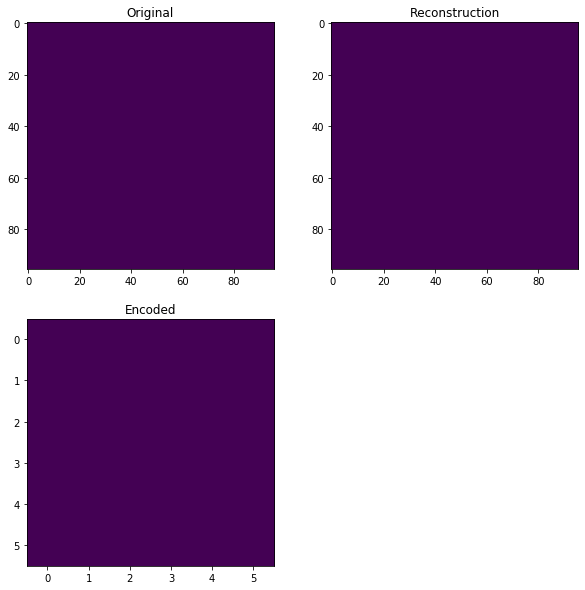

In [39]:
vmin = np.min(data[x1, :, :, 0])
vmax = np.max(data[x1, :, :, 0])

if normalize:
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
else:
    norm = None

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(data[x1, :, :, 0], norm=norm)
plt.subplot(2,2,2)
plt.title("Reconstruction")
plt.imshow(data_reconstructed[x1, :, :, 0], norm=norm)
plt.subplot(2,2,3)
plt.title("Encoded")
plt.imshow(data_encoded[x1, :, :, 0])

# 5. Write to output 

scale back to match original domain

In [40]:
Z_reconstructed = Z_reconstructed * Z_max - np.abs(Z_min)

create output dataset

In [57]:
!cp ../Data/tohoku_2020.nc ../Data/tohoku_2020_reconstruction.nc

In [58]:
out = Dataset('../Data/tohoku_2020_reconstruction.nc', 'r+')
temp  = np.flip(out.variables['elevation'][:], axis=0)

Original and reconstruction min/max altitudes

In [59]:
print("Original max altitude: " + str(np.max(temp)) + " reconstructed: " + str(np.max(Z_reconstructed)))
print("Original min altitude: " + str(np.min(temp)) + " reconstructed: " + str(np.min(Z_reconstructed)))

Original max altitude: 4163 reconstructed: 4195.951845395146
Original min altitude: -10952 reconstructed: -8935.0


Use model output only for actual bathymetry values, i.e. below mean sea level

In [60]:
temp[temp<0] = Z_reconstructed[temp<0]

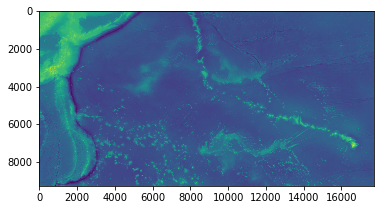

In [61]:
plt.imshow(temp)

In [62]:
out.variables['elevation'][:] = np.flip(temp, axis=0)
out.close()